In [36]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import math
import logging
import numpy as np
import warnings
import common
import random
import dill
import confidence_index as ci
import feature_utils
warnings.filterwarnings("ignore")
random.seed(42)

In [37]:
hy = pd.read_csv("data/Linhac24-25_Sportlogiq.csv")
#hy = hy[ (hy['period'] == 2)]
hy = hy[ (hy['period'] != 4)]
hy['is_offside'] = (hy['eventname'] == 'offside')
hy['is_goal'] = (hy['eventname'] == 'goal')
hy['is_shot'] = hy['eventname'] == 'shot'
hy['is_faceoff_win'] = (hy['eventname'] == 'faceoff') & (hy['outcome'] == 'successful') & (hy['compiledgametime'] == 0)
hy['is_lpr_win'] = (hy['eventname'] == 'lpr') & (hy['outcome'] == 'successful')
hy['is_check'] = hy['eventname'] == 'check'
hy['is_powerplay'] = (hy['manpowersituation'] == 'powerPlay')
hy['is_puckprotection'] = (hy['eventname'] == 'puckprotection') & (hy['outcome'] == 'successful')
hy['is_controlledentryagainst'] = (hy['eventname'] == 'controlledentryagainst') & (hy['outcome'] == 'successful')
hy['is_penaltydrawn'] = (hy['eventname'] == 'penaltydrawn')

first_penalty_drawn = hy[hy['eventname'] == 'penaltydrawn'].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first()[['gameid', 'compiledgametime','teamid','is_penaltydrawn','eventname']]
first_powerplay = hy[hy['is_powerplay']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first()[['gameid', 'compiledgametime','teamid','is_powerplay','manpowersituation']]
first_check =  hy[hy['is_check']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first()[['gameid', 'compiledgametime','teamid','is_check','eventname']]
first_shot =  hy[hy['is_shot']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first()[['gameid', 'compiledgametime','teamid','is_shot','eventname']]
first_goal =  hy[hy['is_goal']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first().reset_index()[['gameid', 'compiledgametime','teamid','is_goal','eventname']]
first_faceoff_win = hy[hy['is_faceoff_win']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first().reset_index()[['gameid', 'compiledgametime','teamid','is_faceoff_win','eventname','outcome']]
first_lpr_win = hy[hy['is_lpr_win']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first().reset_index()[['gameid', 'compiledgametime','teamid','is_lpr_win','eventname','outcome']]
first_puckprotection = hy[hy['is_puckprotection']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first().reset_index()[['gameid', 'compiledgametime','teamid','is_puckprotection','eventname','outcome']]
first_controlledentryagainst = hy[hy['is_controlledentryagainst']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first().reset_index()[['gameid', 'compiledgametime','teaminpossession','is_controlledentryagainst','eventname','outcome']]
first_controlledentryagainst.rename(columns={'teaminpossession': 'teamid'}, inplace=True)
first_offside = hy[hy['is_offside']].sort_values(['gameid', 'compiledgametime']).groupby(['gameid'],as_index=False).first().reset_index()[
    ['gameid', 'compiledgametime', 'teamid', 'is_offside', 'eventname', 'outcome']]

In [38]:
def add_label(row):
    current_gameid = row['gameid']
    winner = common.get_winner(hy, current_gameid)
    is_pin = True if winner[2] is False else False
    winnerid = winner[0] if winner[2] is True else winner[1]
    loserid = winner[1] if winner[2] is True else winner[0]
    return [winnerid,is_pin,loserid]
 
def add_winner_label(df):
    df[['winnerid','is_pin','loserid']] = df.apply(add_label,axis=1, result_type='expand')
    return df


In [39]:
def vectorize_col(df,col):

    df[col] = df[col].astype(int)
    
    return df[['gameid', 'teamid', col]]

def add_home_game_label(row):
    team_id = row['teamid']
    home_team_id = common.get_home_team_id(hy, row['gameid'])
    return 'home' if team_id == home_team_id else 'away'
def add_home_win_label(row):
    gameid = row.name
    winner = common.get_winner(hy, gameid)
    home_team_id = common.get_home_team_id(hy, gameid)
    winnerid = winner[0] if winner[2] is True else winner[1]
    return 1 if home_team_id == winnerid else 0  

vec_first_event = pd.DataFrame()
vec_first_penaltydrawn = vectorize_col(first_penalty_drawn,'is_penaltydrawn')
vec_first_powerplay = vectorize_col(first_powerplay,'is_powerplay')
vec_first_check = vectorize_col(first_check,'is_check')
vec_first_shot = vectorize_col(first_shot,'is_shot')
vec_first_goal = vectorize_col(first_goal,'is_goal')
vec_first_faceoff_win = vectorize_col(first_faceoff_win,'is_faceoff_win')
vec_first_lpr_win = vectorize_col(first_lpr_win,'is_lpr_win')
vec_first_puckprotection = vectorize_col(first_puckprotection,'is_puckprotection')
vec_first_controlledentryagainst = vectorize_col(first_controlledentryagainst,'is_controlledentryagainst')
vec_first_offside = vectorize_col(first_offside,'is_offside')
vec_first_event = pd.merge(vec_first_offside, vec_first_powerplay, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_check, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_shot, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_goal, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_faceoff_win, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_lpr_win, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_puckprotection, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_controlledentryagainst, on=['gameid', 'teamid'], how='outer')
vec_first_event = pd.merge(vec_first_event, vec_first_penaltydrawn, on=['gameid', 'teamid'], how='outer')
vec_first_event = vec_first_event.fillna(0)
vec_first_event['is_home_game'] =vec_first_event.apply(add_home_game_label, axis=1)
vec_first_event = vec_first_event[vec_first_event['gameid'] != 61508]
# vec_first_event['is_home_game'] = vec_first_event.groupby('gameid').cumcount().map({0: 'home', 1: 'away'})
home_df = vec_first_event[vec_first_event['is_home_game'] == 'home'].set_index('gameid')
away_df = vec_first_event[vec_first_event['is_home_game'] == 'away'].set_index('gameid')

# Make sure that the two datasets are aligned by gameid
home_df, away_df = home_df.align(away_df, join='inner', axis=0, fill_value=0)

# Calculate the vector of difference (home team - away team)
diff_df = home_df.drop(columns=['teamid', 'is_home_game']) - away_df.drop(columns=['teamid', 'is_home_game'])
diff_df['home_win'] = diff_df.apply(add_home_win_label, axis=1)
diff_df

,is_offside,is_powerplay,is_check,is_shot,is_goal,is_faceoff_win,is_lpr_win,is_puckprotection,is_controlledentryagainst,is_penaltydrawn,home_win
gameid,,,,,,,,,,,
60062,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
60116,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,0
60266,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
60592,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1
60626,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
88291,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,0
88582,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0
89267,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0


In [40]:

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, 
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
#X = diff_df.drop(columns=['home_win','is_check','is_lpr_win','is_puckprotection'])
X = diff_df.drop(columns=['home_win','is_penaltydrawn','is_controlledentryagainst','is_lpr_win','is_offside']) 
#X #= diff_df.drop(columns=['home_win'])   
features= X.columns.tolist()
#X = diff_df.drop(columns=['home_win'])   

y = diff_df['home_win']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


class_weights = {0: 1, 1: 0.7}
lr = LogisticRegression(class_weight=class_weights, max_iter=500, random_state=42)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lr, X_resampled, y_resampled, cv=cv, scoring='f1')
print(f"Logistic Regression F1 Mean: {scores.mean():.3f} (±{scores.std():.3f})")


y_pred = lr.fit(X_resampled, y_resampled).predict(X_val)
y_proba = lr.predict_proba(X_val)[:, 1]




Logistic Regression F1 Mean: 0.567 (±0.074)


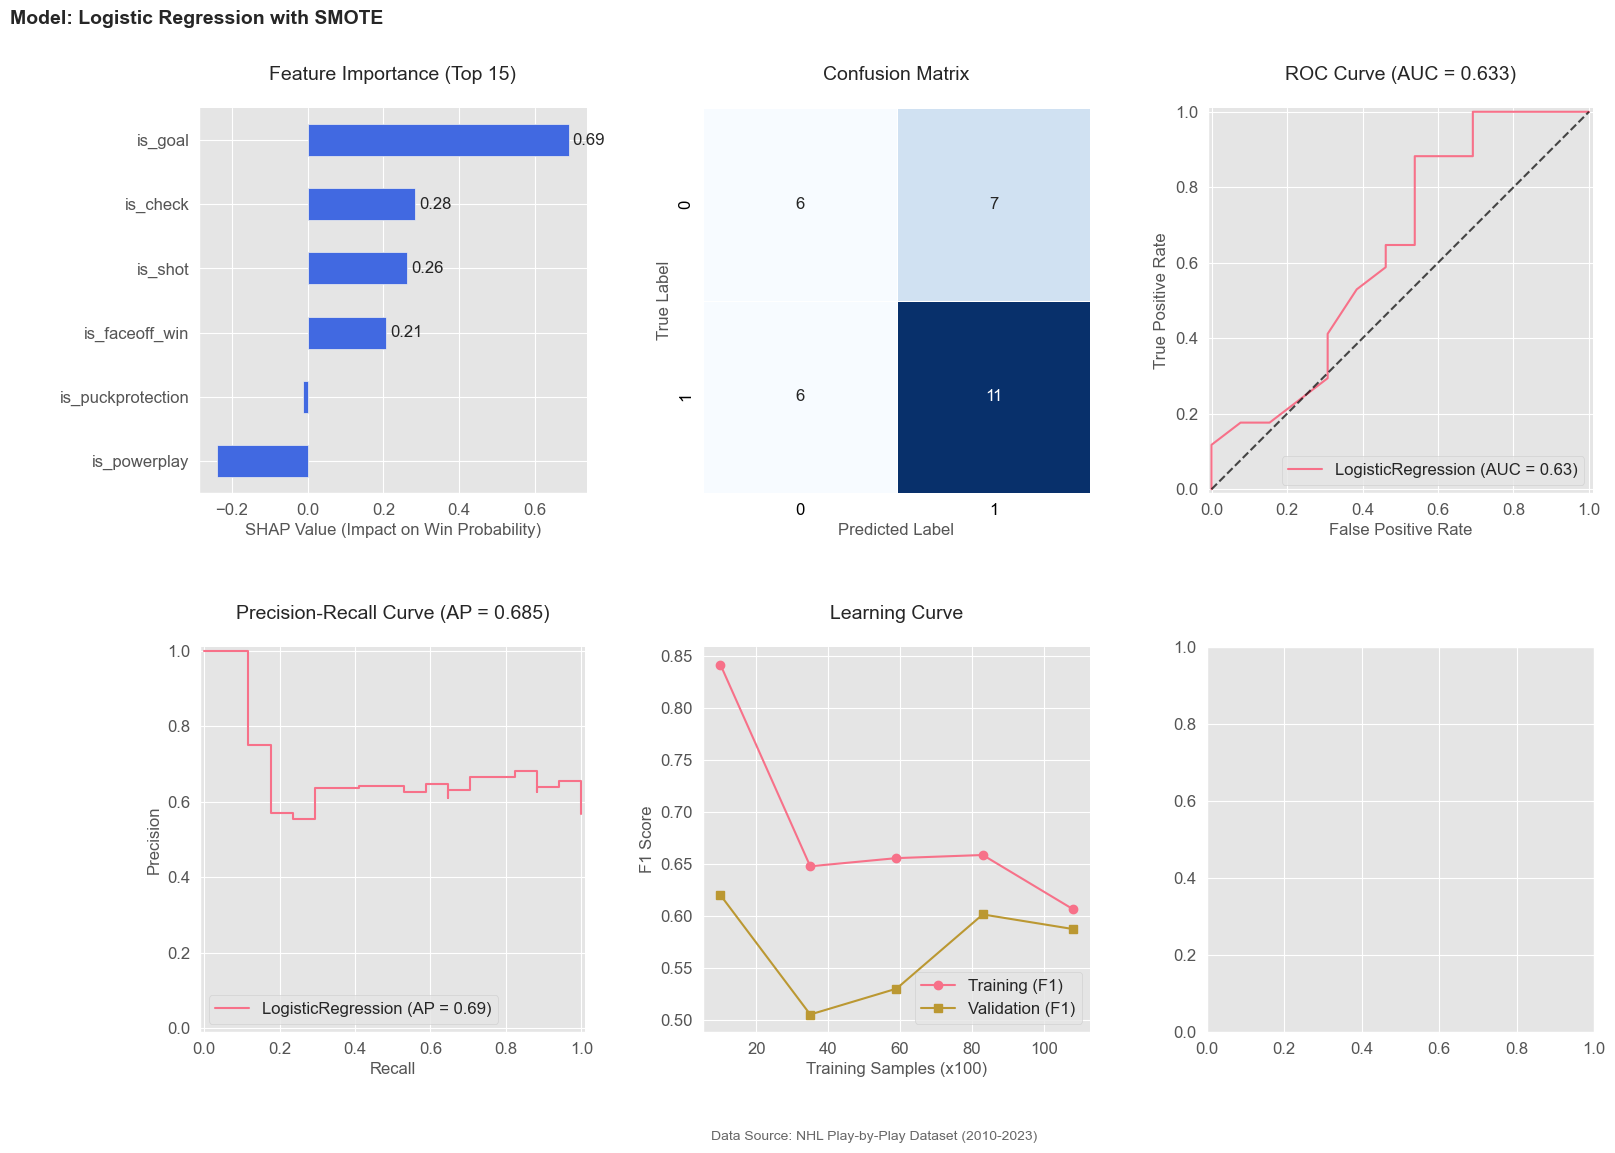

In [41]:
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  
sns.set_palette("husl")        
plt.rcParams['font.size'] = 12  


fig = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.3)



ax1 = fig.add_subplot(grid[0, 0])  
ax2 = fig.add_subplot(grid[0, 1])  
ax3 = fig.add_subplot(grid[0, 2])  


ax4 = fig.add_subplot(grid[1, 0])  
ax5 = fig.add_subplot(grid[1, 1])  
ax6 = fig.add_subplot(grid[1, 2])  



importances = pd.Series(lr.coef_[0], index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)
top_features.plot(kind='barh', ax=ax1, color='royalblue')
ax1.invert_yaxis()
ax1.set_title("Feature Importance (Top 15)", fontsize=14, pad=20)
ax1.set_xlabel("SHAP Value (Impact on Win Probability)", fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for i, v in enumerate(top_features):
    if v > 0.1:  
        ax1.text(v + 0.01, i, f'{v:.2f}', va='center')


cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            ax=ax2, cbar=False, linewidths=0.5)
ax2.set_title("Confusion Matrix", fontsize=14, pad=20)
ax2.set_xlabel("Predicted Label", fontsize=12)
ax2.set_ylabel("True Label", fontsize=12)
ax2.tick_params(axis='both', colors='black')


RocCurveDisplay.from_estimator(lr, X_val, y_val, ax=ax3)
ax3.plot([0,1], [0,1], 'k--', alpha=0.7)  
ax3.set_title("ROC Curve (AUC = {:.3f})".format(roc_auc_score(y_val, y_proba)), 
              fontsize=14, pad=20)
ax3.set_xlabel("False Positive Rate", fontsize=12)
ax3.set_ylabel("True Positive Rate", fontsize=12)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


PrecisionRecallDisplay.from_estimator(lr, X_val, y_val, ax=ax4)
ax4.set_title("Precision-Recall Curve (AP = {:.3f})".format(
    average_precision_score(y_val, y_proba)), 
    fontsize=14, pad=20)
ax4.set_xlabel("Recall", fontsize=12)
ax4.set_ylabel("Precision", fontsize=12)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)


train_sizes, train_scores, val_scores = learning_curve(
    lr, X_resampled, y_resampled, cv=5, 
    scoring='f1', train_sizes=np.linspace(0.1, 1.0, 5))
ax5.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', 
         label="Training (F1)")
ax5.plot(train_sizes, np.mean(val_scores, axis=1), 's-', 
         label="Validation (F1)")
ax5.set_title("Learning Curve", fontsize=14, pad=20)
ax5.set_xlabel("Training Samples (x100)", fontsize=12)
ax5.set_ylabel("F1 Score", fontsize=12)
ax5.legend(loc='lower right')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)


fig.text(0.5, 0.02, "Data Source: NHL Play-by-Play Dataset (2010-2023)", 
         ha='center', fontsize=10, alpha=0.7)
plt.figtext(0.02, 0.95, "Model: Logistic Regression with SMOTE", 
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=50,
    class_weight=class_weights,
    max_depth=4,
    random_state=42
)
rf.fit(X_resampled, y_resampled)

# Feature Importance Analysis
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


is_goal              0.280743
is_powerplay         0.171852
is_faceoff_win       0.157314
is_shot              0.150122
is_check             0.129028
is_puckprotection    0.110941
dtype: float64


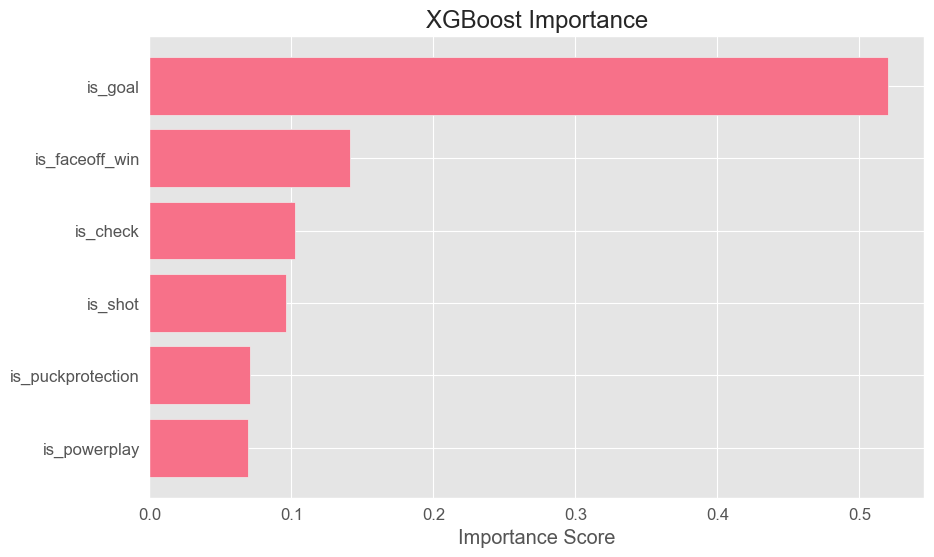

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    scale_pos_weight=0.7,  
    max_depth=5,
    learning_rate=0.1,
    n_estimators=50,
    random_state=42
)
xgb.fit(X_resampled, y_resampled)
feature_importance = xgb.feature_importances_

df_importance = pd.DataFrame({
    'features': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.barh(df_importance['features'], df_importance['importance'])
plt.xlabel('Importance Score')
plt.title('XGBoost Importance')
plt.gca().invert_yaxis()  
plt.show()



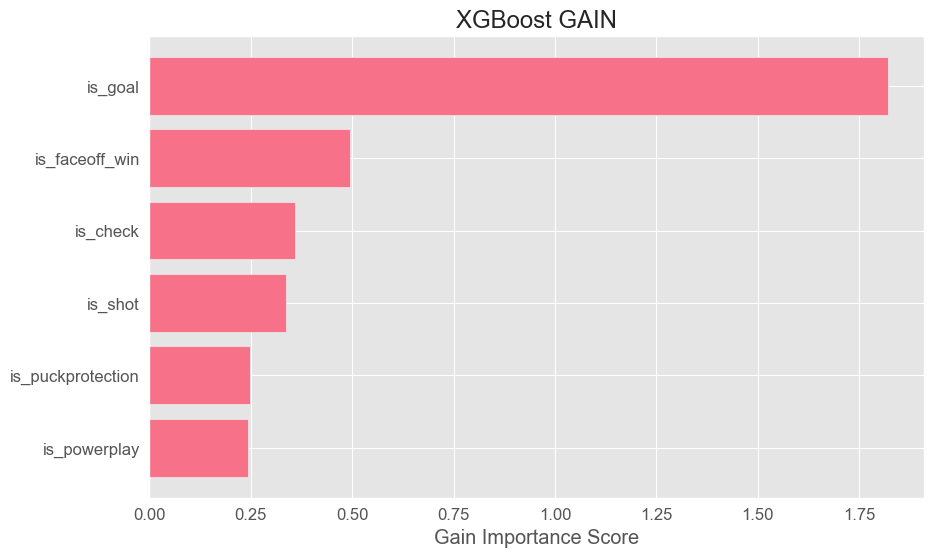

In [44]:

importance_types = ['weight', 'gain', 'cover']
importance_dict = {}

for imp_type in importance_types:
    importance_dict[imp_type] = xgb.get_booster().get_score(importance_type=imp_type)


df_importance['features'] = df_importance['features'].astype(str)
importance_dict['gain'] = {str(k): v for k, v in importance_dict['gain'].items()}


gain_series = pd.Series(importance_dict['gain']).reindex(df_importance['features']).fillna(0)


plt.figure(figsize=(10, 6))
plt.barh(gain_series.index, gain_series.values)
plt.xlabel('Gain Importance Score')
plt.title('XGBoost GAIN')
plt.gca().invert_yaxis()
plt.show()

In [45]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
for model in [lr, rf, xgb]:
    scores = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring='roc_auc')
    print(f"{model.__class__.__name__} AUC: {scores.mean():.3f}")

LogisticRegression AUC: 0.682
RandomForestClassifier AUC: 0.683
XGBClassifier AUC: 0.677


In [46]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

model = rf
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.23      0.29        13
           1       0.55      0.71      0.62        17

    accuracy                           0.50        30
   macro avg       0.46      0.47      0.45        30
weighted avg       0.47      0.50      0.47        30



In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the base model (decision tree)
base_model = DecisionTreeClassifier(
    max_depth=6, 
    class_weight={0:1.65, 1:1}, 
    random_state=42
)

# Bagging Ensemble (10 base models)
bagging_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=20,
    max_samples=0.8,
    bootstrap=True,
    n_jobs=1,  
    bootstrap_features=False,  
    random_state=42  
)

# evaluation
bagging_model.fit(X_train, y_train)
scores = cross_val_score(bagging_model, X_train, y_train, cv=5, scoring='f1')
print(f"Bagging F1 average value: {scores.mean():.3f} (±{scores.std():.3f})")

Bagging F1 average value: 0.570 (±0.092)


In [48]:
import pandas as pd

# Merge the true labels and the predicted labels
results_df = pd.DataFrame({
    'True label': y_train,
    'pred label': bagging_model.predict(X_train)
})

# Group and count by category
print(results_df.groupby(['True label', 'pred label']).size().unstack(fill_value=0))


results_df = pd.DataFrame({
    'True label': y_val,
    'pred label': bagging_model.predict(X_val)
})

# Group and count by category
print(results_df.groupby(['True label', 'pred label']).size().unstack(fill_value=0))

pred label   0   1
True label        
0           39  13
1           15  53
pred label  0   1
True label       
0           4   9
1           6  11


In [49]:
X_resampled

,is_powerplay,is_check,is_shot,is_goal,is_faceoff_win,is_puckprotection
0,1.0,-1.000000,-1.000000,1.0,-1.000000,-1.0
1,-1.0,1.000000,-1.000000,-1.0,-1.000000,-1.0
2,-1.0,-1.000000,1.000000,-1.0,1.000000,1.0
3,-1.0,1.000000,1.000000,1.0,1.000000,-1.0
4,-1.0,1.000000,-1.000000,1.0,-1.000000,-1.0
...,...,...,...,...,...,...
131,1.0,-1.000000,1.000000,-1.0,1.000000,1.0
132,1.0,-0.184829,-0.184829,1.0,-1.000000,-1.0
133,1.0,0.907099,-1.000000,-1.0,1.000000,1.0
134,1.0,-1.000000,-1.000000,-1.0,-1.000000,1.0


In [50]:
vec_first_event

,gameid,teamid,is_offside,is_powerplay,is_check,is_shot,is_goal,is_faceoff_win,is_lpr_win,is_puckprotection,is_controlledentryagainst,is_penaltydrawn,is_home_game
0,60062,634.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,home
1,60062,855.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,away
2,60116,503.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,home
3,60116,869.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,away
4,60266,686.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,89459,814.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,away
303,89459,869.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,home
304,89764,792.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,home
305,89764,855.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,away


In [51]:
vec_first_event

,gameid,teamid,is_offside,is_powerplay,is_check,is_shot,is_goal,is_faceoff_win,is_lpr_win,is_puckprotection,is_controlledentryagainst,is_penaltydrawn,is_home_game
0,60062,634.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,home
1,60062,855.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,away
2,60116,503.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,home
3,60116,869.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,away
4,60266,686.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,89459,814.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,away
303,89459,869.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,home
304,89764,792.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,home
305,89764,855.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,away


first offside win the game rate:0.41, draw in the competition: 0.22, loss rate: 0.37, win number:63,lose number:57, draw number:34,total number:154
first check win the game rate:0.45, draw in the competition: 0.22, loss rate: 0.33, win number:70,lose number:52, draw number:34,total number:156
first powerplay win the game rate:0.37, draw in the competition: 0.21, loss rate: 0.42, win number:57,lose number:65, draw number:32,total number:154
first goal win the game rate:0.54, draw in the competition: 0.22, loss rate: 0.24, win number:85,lose number:37, draw number:34,total number:156
first shot win the game rate:0.47, draw in the competition: 0.22, loss rate: 0.31, win number:74,lose number:48, draw number:34,total number:156
first faceoff win the game rate:0.40, draw in the competition: 0.22, loss rate: 0.38, win number:62,lose number:59, draw number:34,total number:155
first puckprotection win the game rate:0.38, draw in the competition: 0.22, loss rate: 0.40, win number:59,lose number

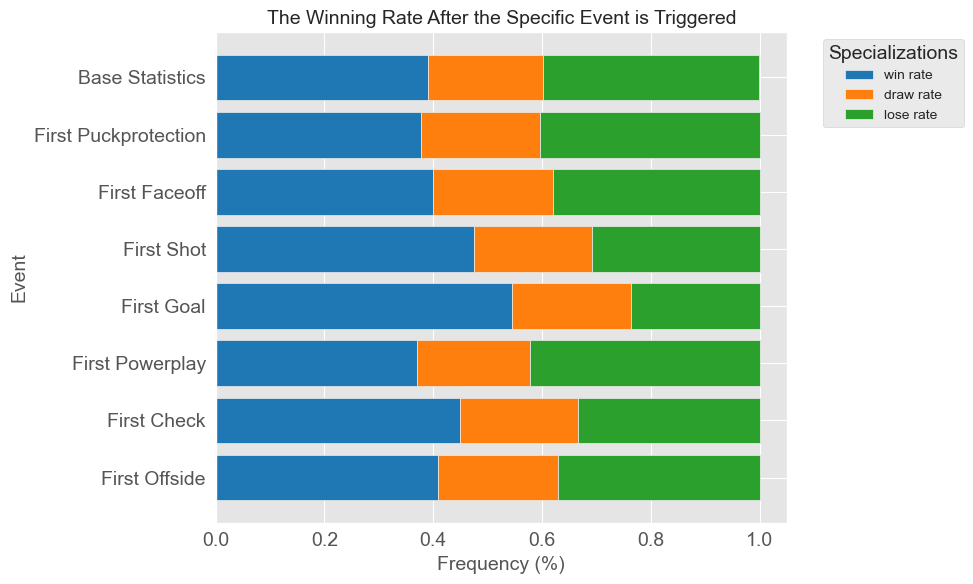

In [52]:
import matplotlib.pyplot as plt
    
def calculate_first_win_rate(df,col):
    win_number = len(df[(df['teamid'] == df['winnerid']) & (df['is_pin'] == False)])
    lose_number = len(df[(df['teamid'] != df['winnerid']) & (df['is_pin'] == False)])
    pin_number = len(df[df['is_pin'] == True])
    win_rate = win_number / len(df['gameid'].unique().tolist())
    pin_rate = pin_number / len(df['gameid'].unique().tolist())
    lose_rate = 1 - win_rate - pin_rate
    print("first {} win the game rate:{:.2f}, draw in the competition: {:.2f}, loss rate: {:.2f}, win number:{},lose number:{}, draw number:{},total number:{}".format(col,win_rate,pin_rate, lose_rate,win_number,lose_number, pin_number,len(df['gameid'].unique().tolist())))
    return pd.DataFrame([{'event':'first_' +col, 'win number': win_number, 'draw number': pin_number, 'total game number': len(df['gameid'].unique().tolist()),'win rate': win_rate, 'draw rate': pin_rate, 'lose rate': lose_rate}])
    
add_winner_label(first_offside)
add_winner_label(first_check)
add_winner_label(first_shot)
add_winner_label(first_goal)
add_winner_label(first_faceoff_win)
add_winner_label(first_puckprotection)
add_winner_label(first_controlledentryagainst)
add_winner_label(first_lpr_win)
add_winner_label(first_powerplay)

foffside_stat_df = calculate_first_win_rate(first_offside,'offside')
fcheck_stat_df =calculate_first_win_rate(first_check,'check')
fpowerplay_stat_df = calculate_first_win_rate(first_powerplay,'powerplay')
fgoal_stat_df = calculate_first_win_rate(first_goal,'goal')
fshot_stat_df = calculate_first_win_rate(first_shot,'shot')
ffaceoff_stat_df = calculate_first_win_rate(first_faceoff_win,'faceoff')
fpuckptet_stat_df = calculate_first_win_rate(first_puckprotection,'puckprotection')
fcea_stat_df = calculate_first_win_rate(first_controlledentryagainst,'controlledentryagainst')
flpr_stat_df = calculate_first_win_rate(first_lpr_win,'lpr')


# 0.40058582721626207
# 0.40129164313946925
# 0.19812252964426874

average_stat_df = pd.DataFrame([{'win rate':0.391,'draw rate':0.21,'lose rate':0.397}])
fevent_stat_df = pd.concat([foffside_stat_df, fcheck_stat_df, fpowerplay_stat_df,fgoal_stat_df,fshot_stat_df,ffaceoff_stat_df,fpuckptet_stat_df], axis=0).reset_index()
levels = ["First Offside",'First Check','First Powerplay','First Goal','First Shot','First Faceoff','First Puckprotection','Base Statistics'] 

display_columns = ['win rate','draw rate','lose rate']
n_specs = len(display_columns)
np.random.seed(42)
display_data = fevent_stat_df.iloc[:, -3:] 
display_data = pd.concat([display_data, average_stat_df], axis=0)
fig, ax = plt.subplots(figsize=(10, 6))

left = np.zeros(len(levels))
colors = plt.cm.tab10.colors  
 
for i in range(n_specs):
    ax.barh(levels, display_data.iloc[:,i ], left=left, color=colors[i % len(colors)],label=display_columns[i])
    left += display_data.iloc[:, i]

ax.set_title("The Winning Rate After the Specific Event is Triggered", fontsize=14)  
ax.set_xlabel("Frequency (%)", fontsize=14)                           
ax.set_ylabel("Event", fontsize=14)                                        
ax.tick_params(axis='both', which='major', labelsize=14)                  
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          title="Specializations", title_fontsize=14, fontsize=10)    
plt.tight_layout()
plt.show()

In [53]:
each_game_df = hy.sort_values(['gameid','teamid']).groupby(['gameid','teamid'],as_index=False).first()[['gameid', 'teamid']]
each_game_df[['winnerid','is_pin','loserid']] = each_game_df.apply(add_label,axis=1, result_type='expand')



In [54]:
#Calculate the average winning rate of each team
print('total team number:', len(each_game_df['teamid'].unique().tolist()))
# each_game_df.drop_duplicates(['gameid'], inplace=True)
win_counts = each_game_df[(each_game_df['is_pin'] == False) & (each_game_df['teamid'] == each_game_df['winnerid'])]['winnerid'].value_counts().reset_index()
draw_counts = each_game_df[each_game_df['is_pin'] == True]['teamid'].value_counts().reset_index()

lose_counts = each_game_df[(each_game_df['is_pin'] == False) & (each_game_df['teamid'] != each_game_df['winnerid'])]['loserid'].value_counts().reset_index()





total team number: 14


In [55]:
res_detail_df= win_counts.merge( draw_counts, 
    left_on='winnerid', 
    right_on='teamid', 
    how='outer' )
res_detail_df.drop(columns=['winnerid'], inplace=True)
res_detail_df = res_detail_df.rename(columns={'count_x': 'win_number', 'count_y': 'draw_number'})
res_detail_df = res_detail_df.merge(lose_counts,left_on='teamid', 
    right_on='loserid', 
    how='outer' )
res_detail_df['win_rate'] = res_detail_df['win_number'] / (res_detail_df['win_number'] + res_detail_df['draw_number'] + res_detail_df['count'])
res_detail_df['lose_rate'] = res_detail_df['count'] / (res_detail_df['win_number'] + res_detail_df['draw_number'] + res_detail_df['count'])
res_detail_df['draw_rate'] = res_detail_df['draw_number'] / (res_detail_df['win_number'] + res_detail_df['draw_number'] + res_detail_df['count'])
res_detail_df



,win_number,teamid,draw_number,loserid,count,win_rate,lose_rate,draw_rate
0,8,503,5,503,9,0.363636,0.409091,0.227273
1,9,524,6,524,8,0.391304,0.347826,0.260870
2,11,628,5,628,7,0.478261,0.304348,0.217391
3,7,634,6,634,9,0.318182,0.409091,0.272727
4,11,686,3,686,8,0.500000,0.363636,0.136364
5,10,726,3,726,9,0.454545,0.409091,0.136364
6,3,792,3,792,16,0.136364,0.727273,0.136364
7,6,795,5,795,11,0.272727,0.500000,0.227273
8,10,814,6,814,6,0.454545,0.272727,0.272727
9,8,825,7,825,7,0.363636,0.318182,0.318182


In [56]:
print(res_detail_df['win_rate'].mean())
print(res_detail_df['lose_rate'].mean())
print(res_detail_df['draw_rate'].mean())

0.391116130246565
0.3915513833992095
0.21733248635422542


In [57]:
  
def get_powerplay_status(group):
    """
    Track the powerplay status for each team in each game.
    Return the status mark of each event (1 = start, -1 = end, 0 = ongoing)
    """
    status = 0
    powerplay_team = None
    status_list = []
    for index, row in group.iterrows():
        gameid = row['gameid']
        current = row['manpowersituation'].lower()
        team_id = row['teamid']
        # Detect powerplay commencement (the current team has entered powerplay)
        if current == 'powerplay' and powerplay_team is None:
            powerplay_team = team_id
            status = 1
            status_list.append(1)       
        # Detect that PowerPlay has ended (the current team has exited PowerPlay)
        elif current != 'powerplay' and status == 1 and powerplay_team == team_id:
            powerplay_team = 'checked'
            status = 0
            status_list.append(-1)  
        # Continuous state or irrelevant team
        else:
            status_list.append(status)
    return status_list


grouped = hy.groupby(['gameid'])
res = pd.DataFrame()
for grp in grouped:
    grp_data = grp[1].copy()
    processed_grp = get_powerplay_status(grp[1])
    grp_data['pp_status'] = processed_grp
    res = pd.concat([res, grp_data], ignore_index=True)
f_powerplay = res[res['pp_status'] == 1]
f_powerplay

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg_allattempts,compiledgametime,...,is_goal,is_shot,is_faceoff_win,is_lpr_win,is_check,is_powerplay,is_puckprotection,is_controlledentryagainst,is_penaltydrawn,pp_status
411,60062,199899.0,634,35236,170439.0,855,NaN,NaN,NaN,352.04,...,False,False,False,False,False,True,False,False,False,1
412,60062,199899.0,634,411721,170439.0,855,855.0,74.0,NaN,352.08,...,False,False,False,True,False,True,False,False,False,1
413,60062,199899.0,634,411721,170439.0,855,855.0,74.0,NaN,352.12,...,False,False,False,False,False,True,False,False,False,1
414,60062,199899.0,634,38465,170439.0,855,855.0,74.0,NaN,352.68,...,False,False,False,False,False,True,False,False,False,1
415,60062,199899.0,634,38465,170439.0,855,855.0,74.0,NaN,353.44,...,False,False,False,False,False,True,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531754,89893,316087.0,792,967261,199899.0,634,634.0,25.0,NaN,160.92,...,False,False,False,False,False,True,False,False,False,1
531755,89893,199899.0,634,512755,316087.0,792,634.0,25.0,NaN,161.00,...,False,False,False,False,False,False,False,False,False,1
531756,89893,316087.0,792,20428,199899.0,634,634.0,25.0,NaN,161.24,...,False,False,False,False,False,True,False,False,False,1
531757,89893,316087.0,792,20428,199899.0,634,634.0,25.0,0.533568,161.28,...,False,True,False,False,False,True,False,False,False,1


In [58]:
shorthand_xg = f_powerplay[(f_powerplay['manpowersituation'] == 'shortHanded') & (f_powerplay['eventname']=='shot')]['xg_allattempts']
print("During the first Powerplay period, the average xG value shot by the shorthand team was：", f_powerplay[(f_powerplay['manpowersituation'] == 'shortHanded') & (f_powerplay['eventname']=='shot')]['xg_allattempts'].mean())

print("During the first powerplay, the average xG of the shorthand team's shots was the same as that of the powerplay team's shots during the first powerplay.：",f_powerplay[(f_powerplay['manpowersituation'] == 'powerPlay') & (f_powerplay['eventname']=='shot')]['xg_allattempts'].mean())

During the first Powerplay period, the average xG value shot by the shorthand team was： 0.05811246450067934
During the first powerplay, the average xG of the shorthand team's shots was the same as that of the powerplay team's shots during the first powerplay.： 0.07048031818152443


In [59]:
#The winning rate of the team that scored the first goal in the Powerplay
first_pwp_goal = res[(res['eventname'] == 'goal') & (res['pp_status'] == 1) & (res['manpowersituation'] == 'powerPlay')]
def add_label(row):
    current_gameid = row['gameid']
    winner = common.get_winner(hy, current_gameid)
    is_pin = True if winner[2] is False else False
    winnerid = winner[0] if winner[2] is True else winner[1]
    loserid = winner[1] if winner[2] is True else winner[0]
    return [winnerid,is_pin,loserid]

def add_winner_label(df):
    df['winnerid'] = None
    df['is_pin'] = None
    df['loserid'] = None
    df[['winnerid','is_pin','loserid']] = df.apply(add_label,axis=1, result_type='expand')
    return df
add_winner_label(first_pwp_goal)
print("goal in first powerplay , win rate is :",len(first_pwp_goal[first_pwp_goal['teamid'] == first_pwp_goal['winnerid']]) / len(first_pwp_goal['gameid'].unique().tolist()))
print("goal in first powerplay , lose rate is :",len(first_pwp_goal[first_pwp_goal['teamid'] == first_pwp_goal['loserid']]) / len(first_pwp_goal['gameid'].unique().tolist()))
first_pwp_goal

goal in first powerplay , win rate is : 0.5897435897435898
goal in first powerplay , lose rate is : 0.41025641025641024


,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg_allattempts,compiledgametime,...,is_lpr_win,is_check,is_powerplay,is_puckprotection,is_controlledentryagainst,is_penaltydrawn,pp_status,winnerid,is_pin,loserid
14361,60626,437682.0,869,952211,71713.0,634,634.0,103.0,NaN,628.86664,...,False,False,True,False,False,False,1,869,True,634
17689,60824,359120.0,686,5038,96649.0,877,877.0,86.0,NaN,571.68000,...,False,False,True,False,False,False,1,686,False,877
55023,62276,359120.0,686,675526,172367.0,814,814.0,85.0,NaN,578.24000,...,False,False,True,False,False,False,1,686,False,814
86425,64669,71713.0,634,484249,464287.0,726,726.0,175.0,NaN,1310.08000,...,False,False,True,False,False,False,1,726,False,634
88995,64765,578487.0,628,141486,882520.0,503,503.0,41.0,NaN,295.53333,...,False,False,True,False,False,False,1,503,False,628
92683,65382,248868.0,524,336459,96649.0,877,877.0,90.0,NaN,588.73334,...,False,False,True,False,False,False,1,877,False,524
103806,66653,578487.0,628,483934,464287.0,726,726.0,158.0,NaN,1088.76000,...,False,False,True,False,False,False,1,726,True,628
106657,67008,24814.0,877,38871,248868.0,524,524.0,77.0,NaN,433.84000,...,False,False,True,False,False,False,1,524,False,877
120789,67557,170439.0,855,467609,189576.0,795,795.0,130.0,NaN,797.76000,...,False,False,True,False,False,False,1,855,False,795
126878,67874,578487.0,628,609414,437682.0,869,869.0,55.0,NaN,329.30000,...,False,False,True,False,False,False,1,869,False,628


In [60]:
# Analysis of the distance of the tackles during the first Powerplay period
player_covered_distance = res[
    ['gameid', 'teamid', 'playerid', 'eventname', 'manpowersituation','xadjcoord', 'yadjcoord', 'outcome', 'pp_status','playerprimaryposition']]
player_covered_distance['n_eventname'] = player_covered_distance['eventname'].shift(-1)
player_covered_distance['nn_eventname'] = player_covered_distance['n_eventname'].shift(-1)
player_covered_distance['nnn_eventname'] = player_covered_distance['nn_eventname'].shift(-1)

player_covered_distance['n_playerid'] = player_covered_distance['playerid'].shift(-1)
player_covered_distance['nn_playerid'] = player_covered_distance['n_playerid'].shift(-1)
player_covered_distance['nnn_playerid'] = player_covered_distance['nn_playerid'].shift(-1)

player_covered_distance['n_teamid'] = player_covered_distance['teamid'].shift(-1)
player_covered_distance['nn_teamid'] = player_covered_distance['n_teamid'].shift(-1)
player_covered_distance['nnn_teamid'] = player_covered_distance['nn_teamid'].shift(-1)

player_covered_distance['n_outcome'] = player_covered_distance['outcome'].shift(-1)
player_covered_distance['nn_outcome'] = player_covered_distance['n_outcome'].shift(-1)
player_covered_distance['nnn_outcome'] = player_covered_distance['nn_outcome'].shift(-1)
# lpr_dumpout_lpr = player_covered_distance[(player_covered_distance['eventname']=='lpr') &
#                                           (player_covered_distance['n_eventname']=='dumpout') & 
#                                             (player_covered_distance['nn_eventname']=='lpr') ]       
# 
# lpr_dumpout_block_lpr = player_covered_distance[(player_covered_distance['eventname']=='lpr') &
#                                           (player_covered_distance['n_eventname']=='dumpout') & 
#                                             (player_covered_distance['nn_eventname']=='block') &
#                                             (player_covered_distance['nnn_eventname']=='lpr')]  
player_covered_distance = player_covered_distance.reset_index()


def get_last_lpr_playerids(row,last_lpr_player_list,pp=False,first_pp=False):
    if first_pp and pp:
        raise Exception("wrong parameters")
    gameid = row['gameid']
    teamid = row['teamid']
    eventname = row['eventname']
    outcome = row['outcome']
    #Based on the aforementioned sequence, calculate the distance between the last player who caught the ball and the one who last appeared. The first lpr was successful. There might be several lpr in the end, and the successful lpr comes from the opposing team.
    if first_pp is True and (row['pp_status'] != 1 or row['manpowersituation'] != 'shortHanded'):
        return
    if eventname == 'dumpout' and outcome == 'successful':
        if pp is True and row['manpowersituation'] != 'shortHanded':
            return
        index = row.name
        end_index = index + 3 if index + 3 < len(player_covered_distance) else len(player_covered_distance) -1
        nearest_lpr_series = player_covered_distance.iloc[index:end_index].query("eventname == 'lpr'")
        if len(nearest_lpr_series) > 0:
            succ_nearest_lpr = nearest_lpr_series[(nearest_lpr_series['teamid'] != teamid) & (nearest_lpr_series['outcome'] == 'successful') & (nearest_lpr_series['gameid'] == gameid)]
            # the nearest lpr is should be the powerplay if pp = True
            succ_nearest_lpr = succ_nearest_lpr[succ_nearest_lpr['manpowersituation'] == 'powerPlay'] if first_pp is True or pp is True else succ_nearest_lpr
            if len(succ_nearest_lpr) > 0:
                nearest_lpr = succ_nearest_lpr.iloc[0]
                # If it is a goalkeeper, return directly and do not count it as the player's running distance.
                if nearest_lpr['playerprimaryposition'] == 'G':
                    return
                nearest_lpr['dumpout_index'] = index
                last_lpr_player_list.extend([nearest_lpr.to_dict()])

def calculate_player_covered_distance(df,first_pp=False,pp=False):
    last_lpr_player_list = list()
    player_covered_distance.apply(get_last_lpr_playerids, axis=1,args=(last_lpr_player_list,pp,first_pp))
    last_lpr_player_df = pd.DataFrame(last_lpr_player_list)
    df_copy = last_lpr_player_df.copy()[['gameid','playerid','index']]
    merged_player_df = df_copy.merge(df, on=['gameid', 'playerid'], how='left')
    merged_player_df['prev_x'] = merged_player_df['xadjcoord'].shift(1)
    merged_player_df['prev_y'] = merged_player_df['yadjcoord'].shift(1)
    merged_player_df = merged_player_df[merged_player_df['index_x'] == merged_player_df['index_y']]
    merged_player_df['covered_dis'] = np.sqrt((merged_player_df['prev_x'] - merged_player_df['xadjcoord'])**2 + (merged_player_df['prev_y'] - merged_player_df['yadjcoord'])**2)
    return merged_player_df

distance_df = calculate_player_covered_distance(player_covered_distance)  
first_pp_distance_df = calculate_player_covered_distance(player_covered_distance,first_pp=True)  
pp_distance_df = calculate_player_covered_distance(player_covered_distance,pp=True)  

print('Average running distance of dumpout:', distance_df['covered_dis'].mean())
print('The average running distance of the first pp dumpout:', first_pp_distance_df['covered_dis'].mean())
print('Average running distance of pp dumpout operation:', pp_distance_df['covered_dis'].mean())




Average running distance of dumpout: 72.11697845433586
The average running distance of the first pp dumpout: 78.62174099255834
Average running distance of pp dumpout operation: 81.9386597615657
